**Run this cell to install all necessary libraries**

In [1]:
pip install pandas numpy joblib matplotlib seaborn scikit-learn xgboost tldextract beautifulsoup4 requests

Note: you may need to restart the kernel to use updated packages.


**Loading dataset**

In [3]:
import pandas as pd

# load the phishing dataset
df = pd.read_csv('PhiUSIIL_Phishing_URL_Dataset.csv') 

# create small sample of dataset for evaluation
eval_df = df.sample(frac=0.1, random_state=42)
eval_df.to_csv('model_testing.csv', index=False)

# group by label and calculate the average URLLength
average_lengths = df.groupby('label')['URLLength'].mean()

for label, avg_length in average_lengths.items():
    print(f"Label: {label}, Average URLLength: {avg_length:.2f}")


Label: 0, Average URLLength: 45.72
Label: 1, Average URLLength: 26.23


**Feature Selection/Analysis**


Correlation with label:
URLSimilarityIndex            0.860358
HasSocialNet                  0.784255
HasCopyrightInfo              0.743358
HasDescription                0.690232
IsHTTPS                       0.609132
DomainTitleMatchScore         0.584905
HasSubmitButton               0.578561
IsResponsive                  0.548608
URLTitleMatchScore            0.539419
SpacialCharRatioInURL        -0.533537
HasHiddenFields               0.507731
HasFavicon                    0.493711
URLCharProb                   0.469749
CharContinuationRate          0.467735
HasTitle                      0.459725
DegitRatioInURL              -0.432032
Robots                        0.392620
NoOfJS                        0.373500
LetterRatioInURL             -0.367794
Pay                           0.359747
NoOfOtherSpecialCharsInURL   -0.358891
NoOfSelfRef                   0.316211
DomainLength                 -0.283152
NoOfImage                     0.274658
LineOfCode                    0.272257


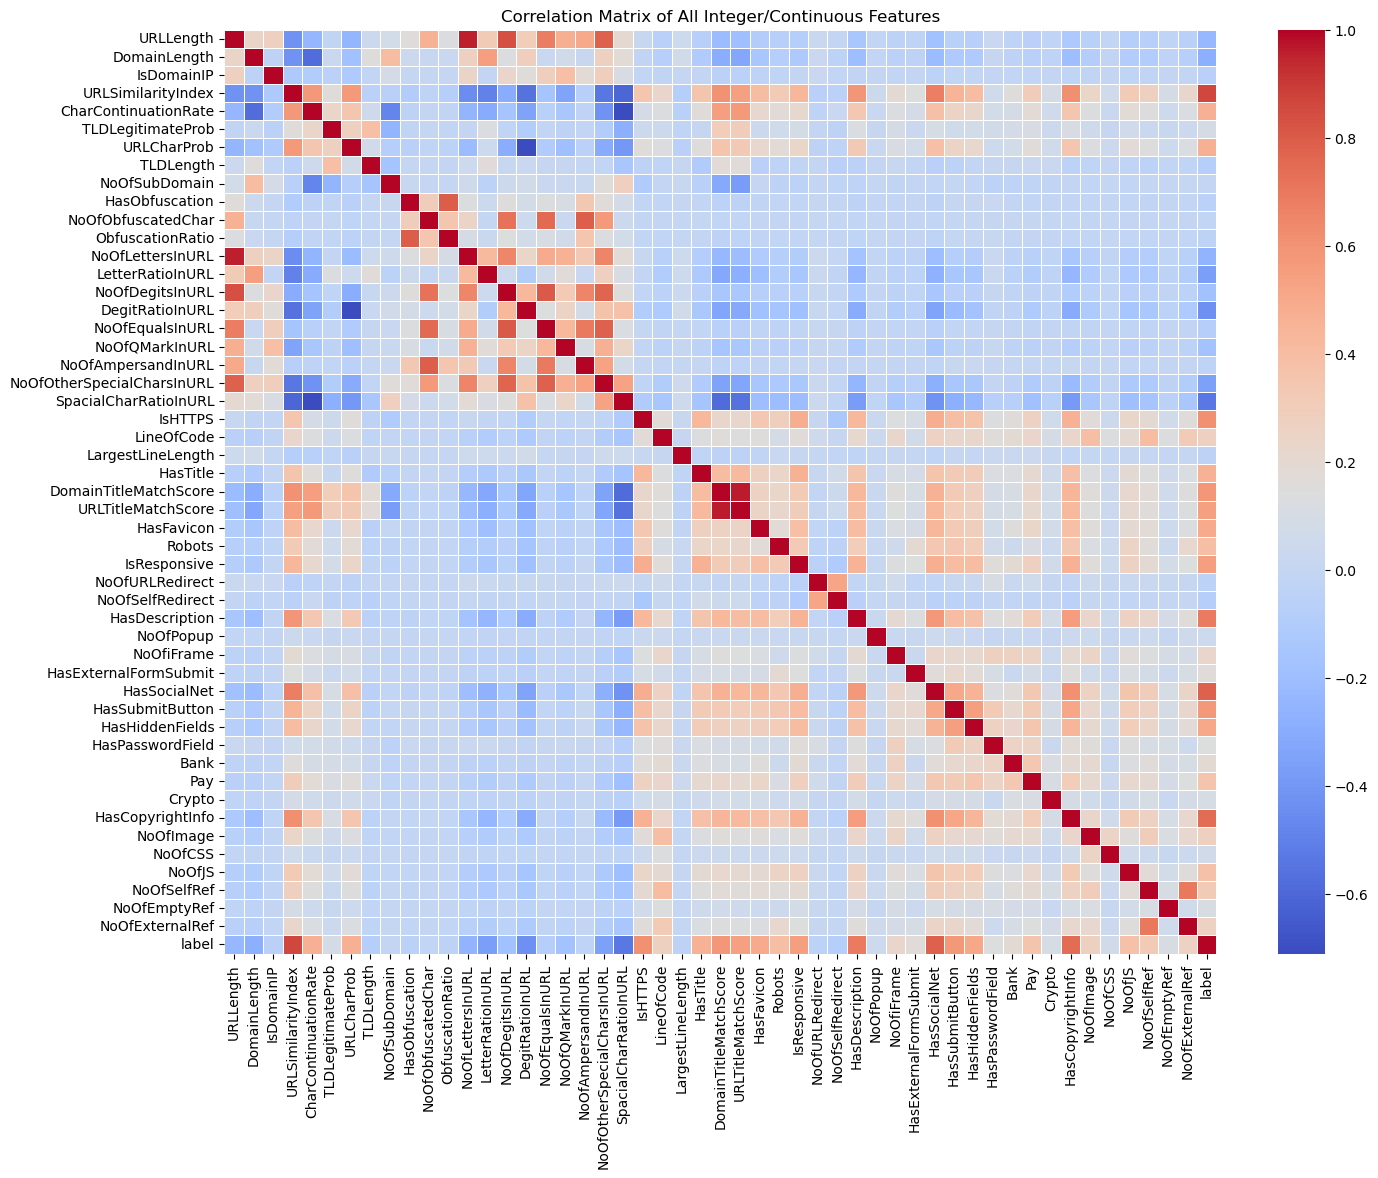

In [5]:
# create correlation matrix to see which features are heavily correlated with label
import seaborn as sns
import matplotlib.pyplot as plt

corr_df = df.copy()

# drop categorical features/colums
corr_df = corr_df.drop(columns=['FILENAME', 'URL', 'Domain', 'Title', 'TLD'])

# Compute correlation matrix
corr_matrix = corr_df.corr(numeric_only=True)

# show feature correlation with label in order
label_corr = corr_matrix["label"].drop("label").sort_values(key=abs, ascending=False)
print("\nCorrelation with label:")
print(label_corr)

# heatmap
plt.figure(figsize=(16, 12))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Correlation Matrix of All Integer/Continuous Features")
plt.show()

Looking at the correlation matrix and heatmap, we are looking to see which features in our dataset are heavily correlated with predicting if a website is legitimate or not.

We can see that URLSimilarityIndex, HasSocialNet, HasCopyrightInfo, HasDescription, IsHTTPS, DomainTitleMatchScore, HasSubmitButton, IsResponsive, URLTitleMatchScore, SpacialCharRatioInURL, HasHiddenFields are the features with a correlation greater than 0.5 with the label. Looking at these features in-depth and what they are, we choose to remove URLSimilarityIndex, DomainTitleMatchScore, and URLTitleMatchScore first from the feature list. This is because these are the features that require implementation and can't be implemented given the project's timeframe. 

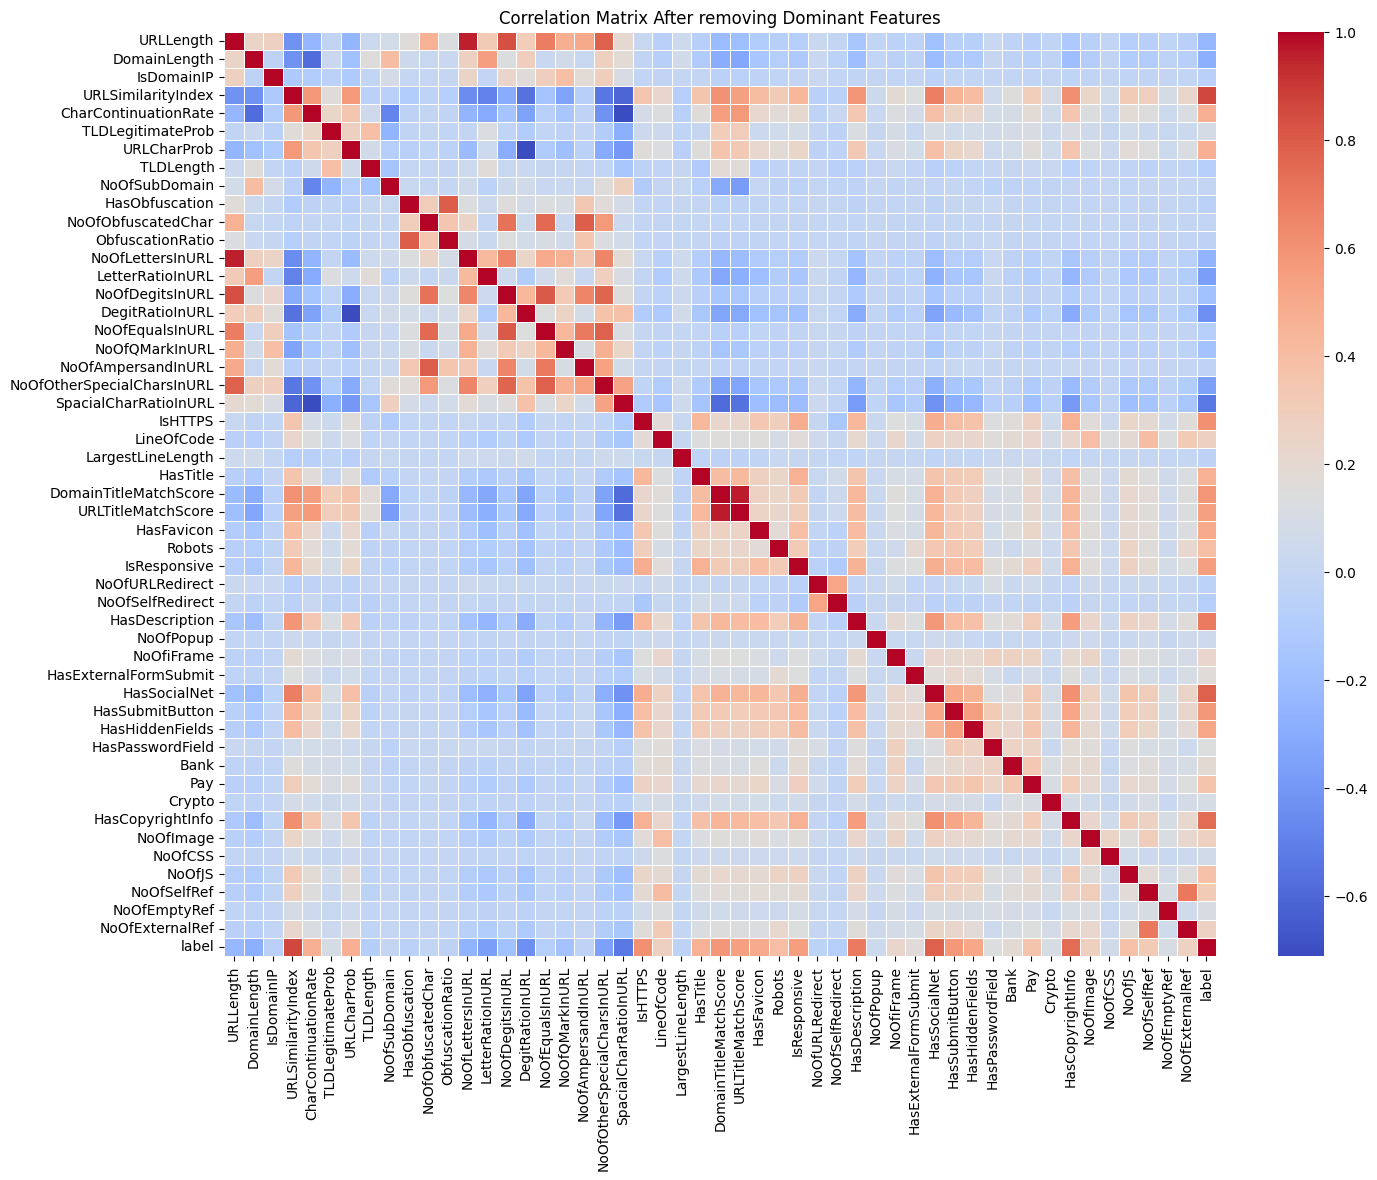

In [16]:
# drop highly correlated columns
corr_df = corr_df.drop(columns=['URLSimilarityIndex', 'DomainTitleMatchScore', 'URLTitleMatchScore'], errors="ignore")

# heatmap
plt.figure(figsize=(16, 12))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Correlation Matrix After removing Dominant Features")
plt.show()

With this correlation matrix, the main goal is to look for any features that are correlated to one another, meaning they could be redundant. From the correlation matrix, we can see that URLLength is also highly correlated with NoOfLettersInURL, NoOfDegitsInURL, NoOfSpecialCharactersInURL. Based on general knowledge, this all makes sense since the URLLength is broken up into multiple features that help break down the URL. For the main features, we have two categories that are related to URLLength: Character Count features and Character Ratio features.

Character Count features only calculate the number of times a character is in a URL, while Character Ratio features calculate the number of times a character is in URL and normalizes it with the URL length. 

We have to make a decision on which features we want to keep or are more valuable for training our model. In our case, we are going to remove the features that list the number of certain characters that appear in the URL, since the ratios of these elements would be better fitted for deciding if a label is phishing or not.

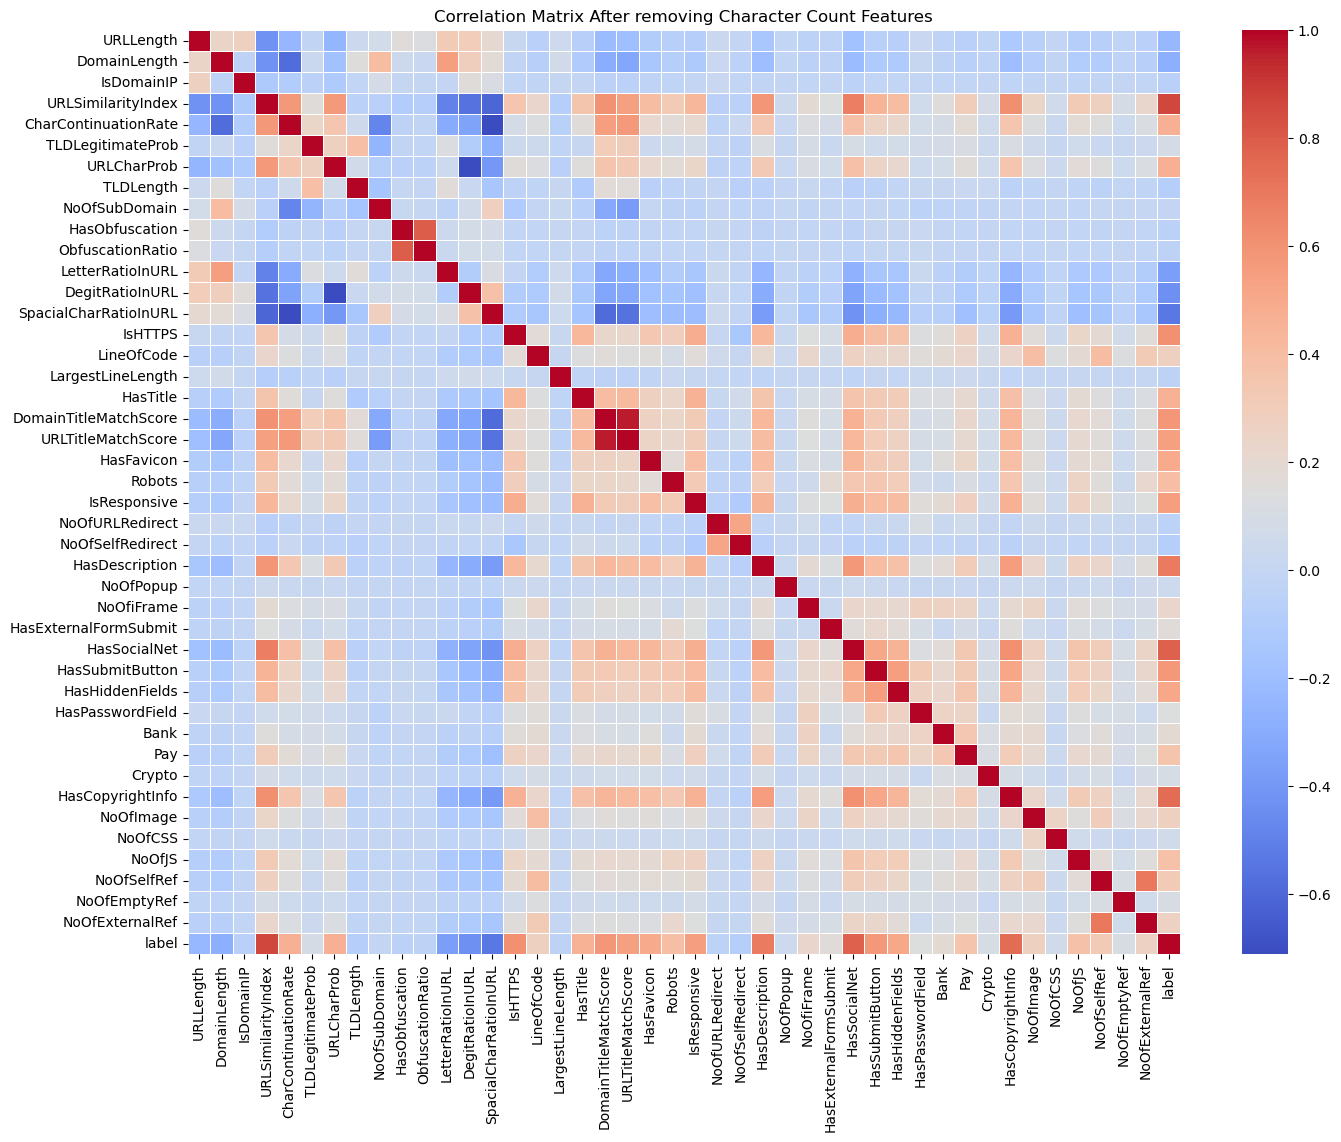

In [7]:
# dropping all the character count features
corr_df = corr_df.drop(columns=['NoOfLettersInURL', 'NoOfDegitsInURL', 'NoOfSpecialCharactersInURL', 'NoOfObfuscatedChar',
                                'NoOfEqualsInURL', 'NoOfQMarkInURL', 'NoOfAmpersandInURL', 'NoOfOtherSpecialCharsInURL'], errors="ignore")
corr_matrix = corr_df.corr(numeric_only=True)

plt.figure(figsize=(16, 12))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Correlation Matrix After removing Character Count Features")
plt.show()

After reducing the feature set, we want to now remove the features that have low or zero variance since it means the model won't learn anything from it or help the model in differentiating whether a link is legitimate or not. By keeping these features, we also risk overfitting and adding extra noise to the model.

In [9]:
from sklearn.feature_selection import VarianceThreshold
import numpy as np

numeric_data = corr_df.select_dtypes(include=[np.number]).drop(columns=["label"], errors="ignore")

# find features with zero variance
selector = VarianceThreshold(threshold=0.05)
selector.fit(numeric_data)

# save the features that have zero to low variance
removed_features = numeric_data.columns[~selector.get_support()]

print("Low or zero variance features:")
print(removed_features.tolist())

Low or zero variance features:
['IsDomainIP', 'CharContinuationRate', 'URLCharProb', 'HasObfuscation', 'ObfuscationRatio', 'LetterRatioInURL', 'DegitRatioInURL', 'SpacialCharRatioInURL', 'NoOfSelfRedirect', 'HasExternalFormSubmit', 'Crypto']


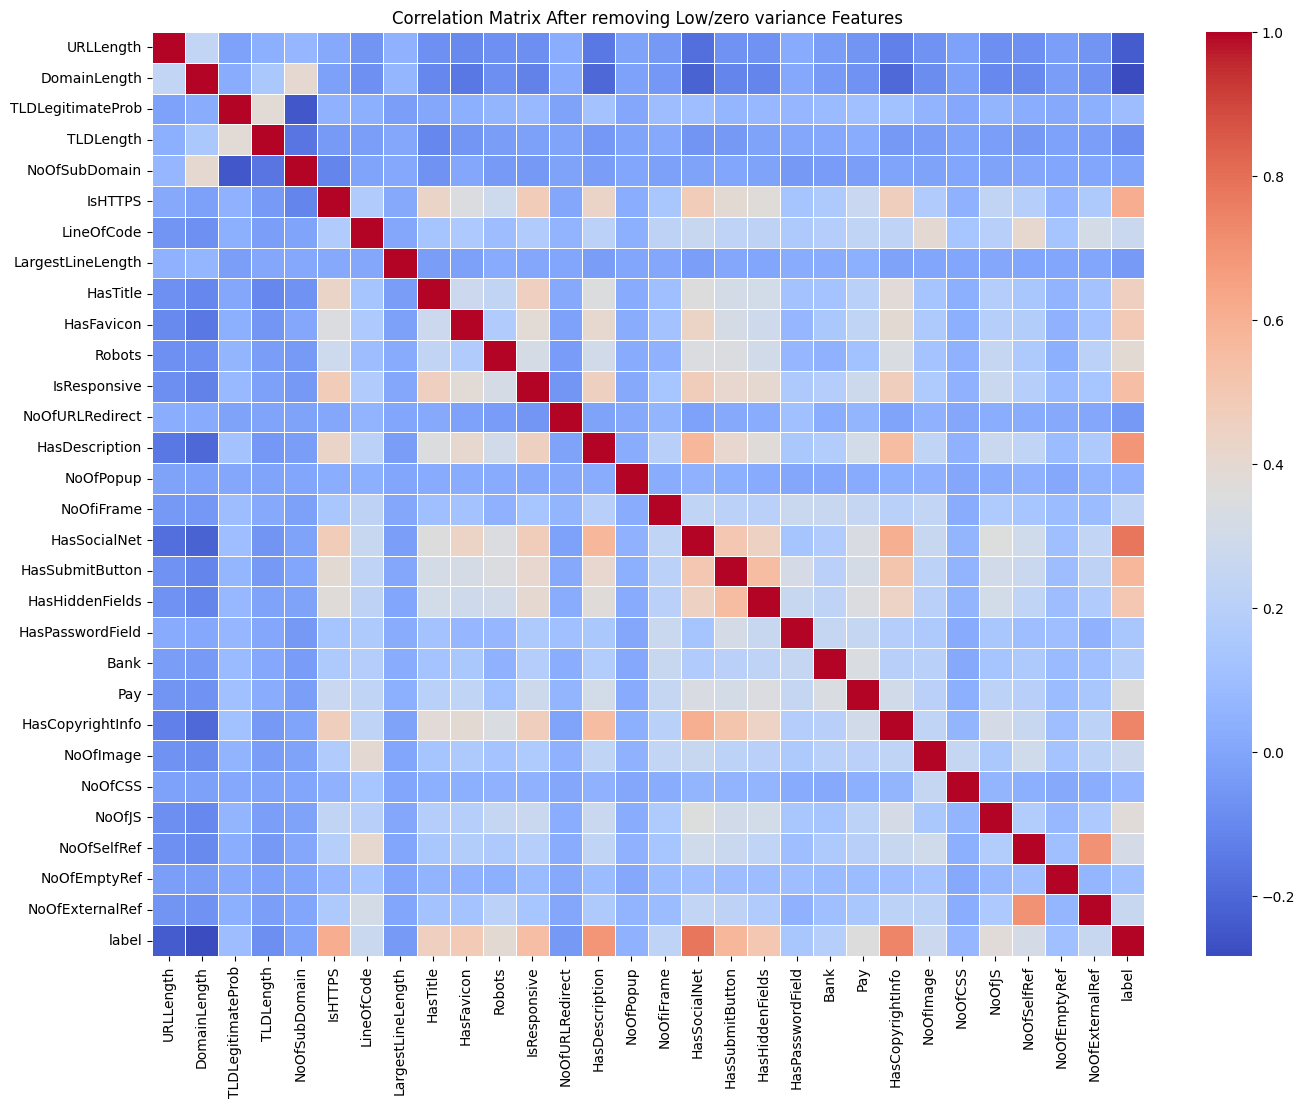

In [20]:
# dropping features with zero or very low variance
corr_df = corr_df.drop(columns=['IsDomainIP', 'CharContinuationRate', 'URLCharProb', 'HasObfuscation', 
                                'ObfuscationRatio', 'LetterRatioInURL', 'DegitRatioInURL', 'SpacialCharRatioInURL', 
                                'NoOfSelfRedirect', 'HasExternalFormSubmit', 'Crypto'], errors="ignore")
corr_matrix = corr_df.corr(numeric_only=True)

plt.figure(figsize=(16, 12))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Correlation Matrix After removing Low/zero variance Features")
plt.show()

Now, with our reduced feature set, we want to look at each feature's importance in determining whether a URL is phishing or legitimate. To achieve this, we trained a basic RandomForest classifier to calculate the feature importance scores and plotted it to better visualize.

Index(['URLLength', 'DomainLength', 'IsDomainIP', 'URLSimilarityIndex',
       'CharContinuationRate', 'TLDLegitimateProb', 'URLCharProb', 'TLDLength',
       'NoOfSubDomain', 'HasObfuscation', 'ObfuscationRatio',
       'LetterRatioInURL', 'DegitRatioInURL', 'SpacialCharRatioInURL',
       'IsHTTPS', 'LineOfCode', 'LargestLineLength', 'HasTitle',
       'DomainTitleMatchScore', 'URLTitleMatchScore', 'HasFavicon', 'Robots',
       'IsResponsive', 'NoOfURLRedirect', 'NoOfSelfRedirect', 'HasDescription',
       'NoOfPopup', 'NoOfiFrame', 'HasExternalFormSubmit', 'HasSocialNet',
       'HasSubmitButton', 'HasHiddenFields', 'HasPasswordField', 'Bank', 'Pay',
       'Crypto', 'HasCopyrightInfo', 'NoOfImage', 'NoOfCSS', 'NoOfJS',
       'NoOfSelfRef', 'NoOfEmptyRef', 'NoOfExternalRef'],
      dtype='object')


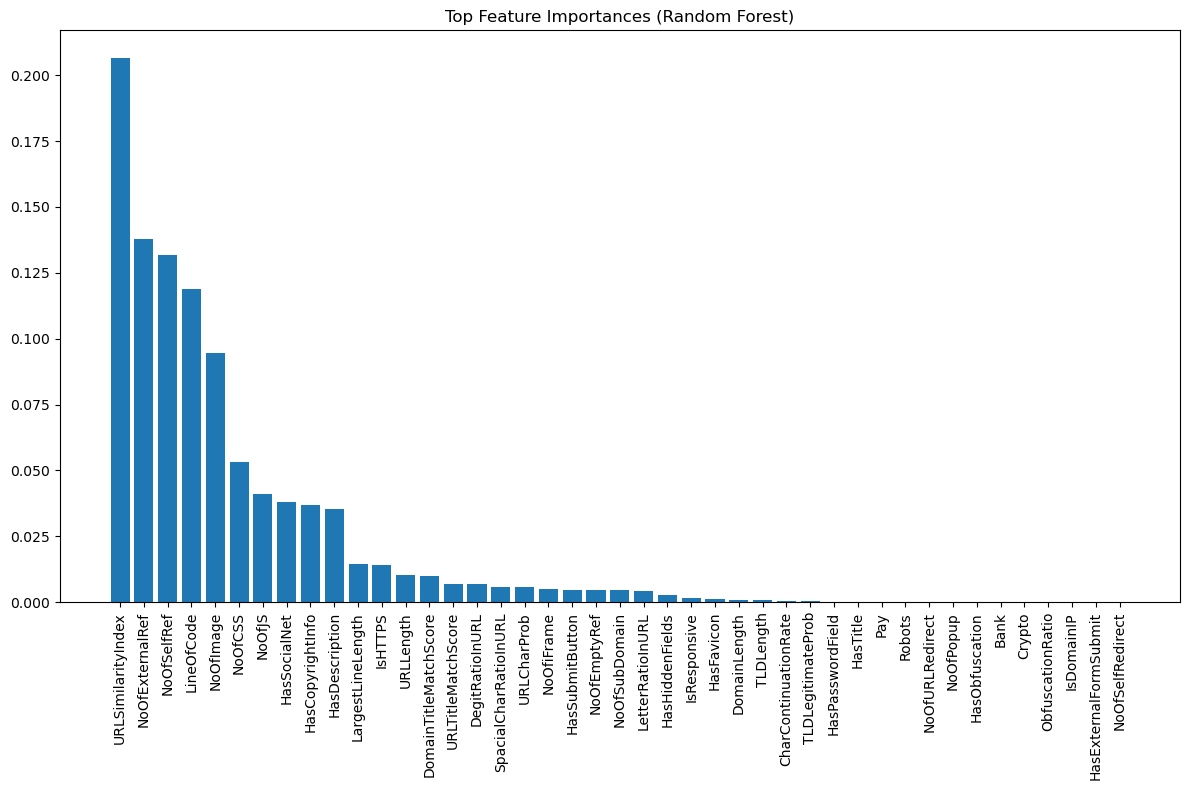

In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

X = corr_df.drop('label', axis=1)
y = corr_df['label']

# split dataset into training and testing 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# use RandomForest model for feature importance
model = RandomForestClassifier(class_weight='balanced', random_state=42)
model.fit(X_train, y_train)

importances = model.feature_importances_
feature_names = X.columns  
indices = np.argsort(importances)[::-1]
print(feature_names)

# plotting the features that are important to classification
plt.figure(figsize=(12, 8))
plt.title("Top Feature Importances (Random Forest)")
plt.bar(range(len(importances)), importances[indices], align="center")
plt.xticks(range(len(importances)), feature_names[indices], rotation=90)
plt.tight_layout()
plt.show()


After looking at the plot, we looked through the features to make one final assessment on which ones we should or shouldn't remove. The dataset provided a paper with insight on each feature's purpose and we came to the conclusion to remove certain features like LineOfCode, URLLength, LargestLineLength. These features are heavily important in detecting phishing but with how our model performed, these features can crete a certain bias towards URLs with lots of code. The main objective is to choose the best model that also produces the least amount of false negatives.

In [15]:
import pandas as pd
import joblib
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, StratifiedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


X = df.drop('label', axis=1)
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# features chosen after feature engineering/analysis
numeric_features = [
    "DomainLength", "NoOfImage", "NoOfCSS", "NoOfJS", "NoOfExternalRef",
    "NoOfSubDomain", "NoOfURLRedirect", "NoOfSelfRedirect", "NoOfPopup", "NoOfiFrame", "NoOfSelfRef",
     "IsHTTPS", "HasTitle", "HasDescription", "HasFavicon", "Robots", "IsResponsive", "HasCopyrightInfo", "HasSocialNet",
    "HasSubmitButton", "HasHiddenFields", "Bank", "Pay"
]

categorical_features = ["TLD"]

def create_training_pipeline(classifier, scaler='standard'):

    # choose the correct scaler
    if scaler == 'minmax':
        scaler_instance = MinMaxScaler()
        # for Naive bayes
        one_hot = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
    else:
        scaler_instance = StandardScaler()
        one_hot = OneHotEncoder(handle_unknown="ignore") 

    preprocessor = ColumnTransformer([
        ("num", scaler_instance, numeric_features),
        ("cat", one_hot, categorical_features)
    ])

    pipeline = Pipeline([
        ("preprocessor", preprocessor),
        ("classifier", classifier)
    ])

    return pipeline

**Model Evaluation**

Cross-Validated F1 Scores: [0.99861953 0.99845692 0.99891728 0.998484   0.99897143]
Average CV F1 Score: 0.9986898333569109
Accuracy: 0.9984732500689157
Classification Report:
               precision    recall  f1-score   support

           0     0.9990    0.9975    0.9982     20189
           1     0.9981    0.9992    0.9987     26970

    accuracy                         0.9985     47159
   macro avg     0.9985    0.9983    0.9984     47159
weighted avg     0.9985    0.9985    0.9985     47159



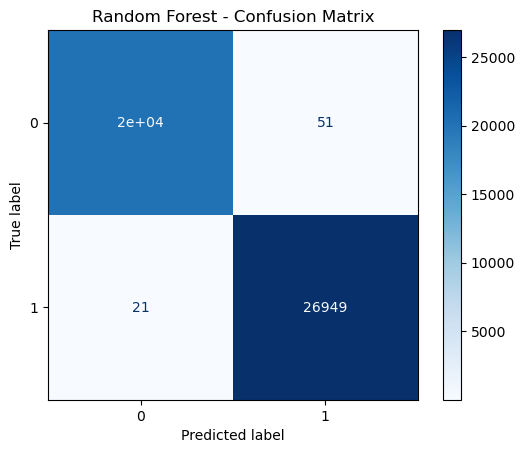

In [17]:
# Random Forest model evaluation

pipeline = create_training_pipeline(RandomForestClassifier(class_weight='balanced', random_state=42))
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring='f1_macro')
print("Cross-Validated F1 Scores:", cv_scores)
print("Average CV F1 Score:", cv_scores.mean())

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred, digits=4))
ConfusionMatrixDisplay.from_estimator(pipeline, X_test, y_test, cmap='Blues')
plt.title("Random Forest - Confusion Matrix")
plt.show()

Cross-Validated F1 Scores: [0.99318427 0.99421086 0.99467258 0.99377755 0.99456358]
Average CV F1 Score: 0.9940817684765367
Logistic Regression - Accuracy: 0.9938293856952013
Classification Report:
               precision    recall  f1-score   support

           0     0.9904    0.9952    0.9928     20189
           1     0.9964    0.9928    0.9946     26970

    accuracy                         0.9938     47159
   macro avg     0.9934    0.9940    0.9937     47159
weighted avg     0.9938    0.9938    0.9938     47159



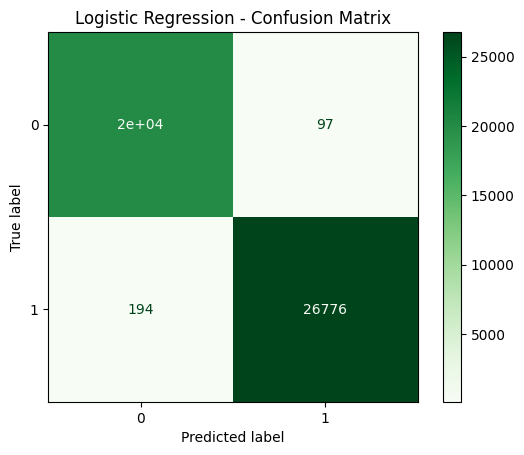

In [50]:
# Logistic Regression model evaluation
from sklearn.linear_model import LogisticRegression

lr_pipeline = create_training_pipeline(LogisticRegression(class_weight='balanced', max_iter=1000), scaler='standard')
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_scores = cross_val_score(lr_pipeline, X_train, y_train, cv=cv, scoring='f1_macro')
print("Cross-Validated F1 Scores:", cv_scores)
print("Average CV F1 Score:", cv_scores.mean())

lr_pipeline.fit(X_train, y_train)
y_pred_lr = lr_pipeline.predict(X_test)

print("Logistic Regression - Accuracy:", accuracy_score(y_test, y_pred_lr))
print("Classification Report:\n", classification_report(y_test, y_pred_lr, digits=4))
ConfusionMatrixDisplay.from_estimator(lr_pipeline, X_test, y_test, cmap='Greens')
plt.title("Logistic Regression - Confusion Matrix")
plt.show()

Cross-Validated F1 Scores: [0.81052995 0.84244698 0.84755149 0.83900219 0.81085966]
Average CV F1 Score: 0.8300780539040147
Naive Bayes - Accuracy: 0.8323119659025848
Classification Report:
               precision    recall  f1-score   support

           0     0.9876    0.6160    0.7588     20189
           1     0.7757    0.9942    0.8715     26970

    accuracy                         0.8323     47159
   macro avg     0.8817    0.8051    0.8151     47159
weighted avg     0.8664    0.8323    0.8232     47159



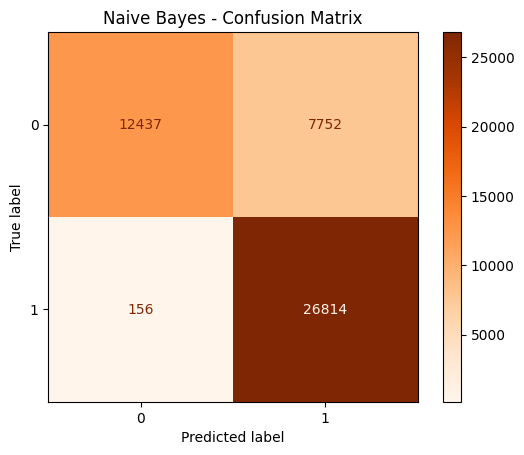

In [52]:
# Naive Bayes model evaluation
from sklearn.naive_bayes import GaussianNB

pipeline = create_training_pipeline(GaussianNB(), scaler='minmax')
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring='f1_macro')
print("Cross-Validated F1 Scores:", cv_scores)
print("Average CV F1 Score:", cv_scores.mean())

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

print("Naive Bayes - Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred, digits=4))
ConfusionMatrixDisplay.from_estimator(pipeline, X_test, y_test, cmap='Oranges')
plt.title("Naive Bayes - Confusion Matrix")
plt.show()

Cross-Validated F1 Scores: [0.99122505 0.99182547 0.99225844 0.99095774 0.99130921]
Average CV F1 Score: 0.9915151822900649
KNN - Accuracy: 0.9920481774422698
Classification Report:
               precision    recall  f1-score   support

           0     0.9921    0.9894    0.9907     20189
           1     0.9920    0.9941    0.9931     26970

    accuracy                         0.9920     47159
   macro avg     0.9920    0.9917    0.9919     47159
weighted avg     0.9920    0.9920    0.9920     47159



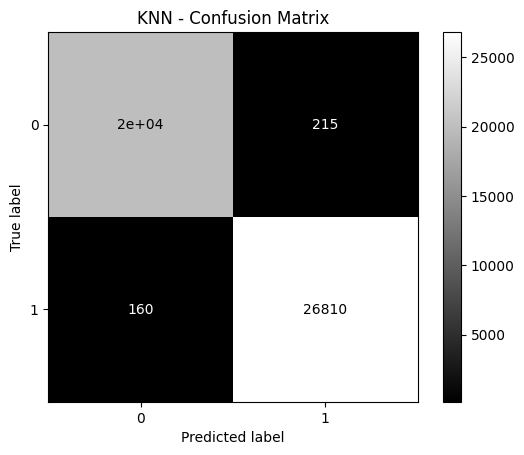

In [53]:
# model evaluation for KNN

from sklearn.neighbors import KNeighborsClassifier

pipeline = create_training_pipeline(KNeighborsClassifier(n_neighbors=5))
## beware: running cross-validation can take a long time with KNN ##
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring='f1_macro')
print("Cross-Validated F1 Scores:", cv_scores)
print("Average CV F1 Score:", cv_scores.mean())

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

print("KNN - Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred, digits=4))
ConfusionMatrixDisplay.from_estimator(pipeline, X_test, y_test, cmap='gray')
plt.title("KNN - Confusion Matrix")
plt.show()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [23:05:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [23:05:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [23:05:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [23:05:19] WARN

Cross-Validated F1 Scores: [0.99848432 0.99843001 0.99859264 0.99853835 0.99880908]
Average CV F1 Score: 0.9985708805100924


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [23:05:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost - Accuracy: 0.9983036111876842
Classification Report:
               precision    recall  f1-score   support

           0     0.9986    0.9974    0.9980     20189
           1     0.9981    0.9990    0.9985     26970

    accuracy                         0.9983     47159
   macro avg     0.9983    0.9982    0.9983     47159
weighted avg     0.9983    0.9983    0.9983     47159



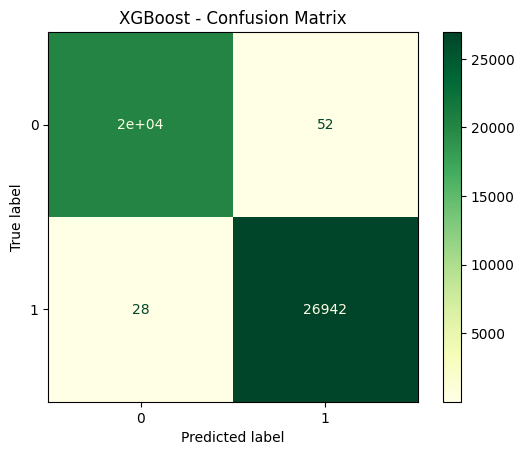

In [54]:
# XGBoost model evaluation
from xgboost import XGBClassifier

pipeline = create_training_pipeline(
    classifier=XGBClassifier(
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=42,
        n_jobs=-1
    )
)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring='f1_macro')
print("Cross-Validated F1 Scores:", cv_scores)
print("Average CV F1 Score:", cv_scores.mean())

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

print("XGBoost - Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred, digits=4))
ConfusionMatrixDisplay.from_estimator(pipeline, X_test, y_test, cmap='YlGn')
plt.title("XGBoost - Confusion Matrix")
plt.show()

**Parameter Finetuning**

Fitting 5 folds for each of 20 candidates, totalling 100 fits

Best Parameters Found:
 {'classifier__n_estimators': 100, 'classifier__min_samples_split': 5, 'classifier__min_samples_leaf': 1, 'classifier__max_features': 'log2', 'classifier__max_depth': None}
Accuracy: 0.9980703577259908
Classification Report:
               precision    recall  f1-score   support

           0     0.9991    0.9964    0.9977     20189
           1     0.9973    0.9993    0.9983     26970

    accuracy                         0.9981     47159
   macro avg     0.9982    0.9979    0.9980     47159
weighted avg     0.9981    0.9981    0.9981     47159



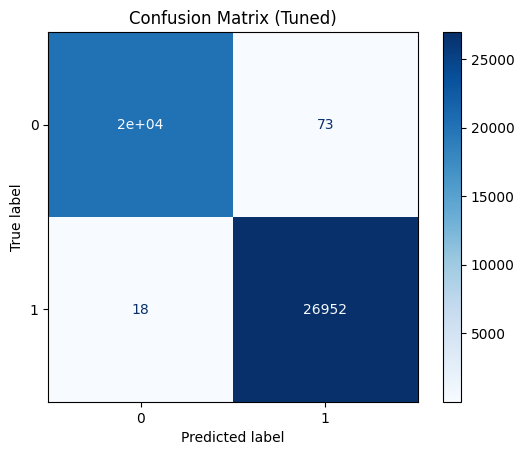

[CV] END classifier__max_depth=30, classifier__max_features=log2, classifier__min_samples_leaf=2, classifier__min_samples_split=5, classifier__n_estimators=100; total time=  14.9s
[CV] END classifier__max_depth=20, classifier__max_features=log2, classifier__min_samples_leaf=1, classifier__min_samples_split=5, classifier__n_estimators=100; total time=  13.0s
[CV] END classifier__max_depth=None, classifier__max_features=sqrt, classifier__min_samples_leaf=2, classifier__min_samples_split=10, classifier__n_estimators=100; total time=  26.8s
[CV] END classifier__max_depth=30, classifier__max_features=sqrt, classifier__min_samples_leaf=4, classifier__min_samples_split=2, classifier__n_estimators=300; total time= 1.1min
[CV] END classifier__max_depth=30, classifier__max_features=log2, classifier__min_samples_leaf=2, classifier__min_samples_split=10, classifier__n_estimators=200; total time=  29.4s
[CV] END classifier__max_depth=20, classifier__max_features=log2, classifier__min_samples_leaf=4

In [47]:
from sklearn.model_selection import RandomizedSearchCV

def train_model_with_tuning(df, target_column='label', model_path='url_classifier_model_fine_tuned.joblib'):
    X = df.drop(target_column, axis=1)
    y = df[target_column]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


    pipeline = create_training_pipeline(
    classifier=RandomForestClassifier(class_weight="balanced", random_state=42),
    scaler='standard'
    )


    param_grid = {
        'classifier__n_estimators': [100, 200, 300],
        'classifier__max_depth': [None, 10, 20, 30],
        'classifier__min_samples_split': [2, 5, 10],
        'classifier__min_samples_leaf': [1, 2, 4],
        'classifier__max_features': ['sqrt', 'log2']
    }


    search = RandomizedSearchCV(
        estimator=pipeline,
        param_distributions=param_grid,
        n_iter=20,
        scoring='f1',
        n_jobs=-1,
        cv=5,
        verbose=2,
        random_state=42
    )

    search.fit(X_train, y_train)
    best_pipeline = search.best_estimator_
    print("\nBest Parameters Found:\n", search.best_params_)
    
    y_pred = best_pipeline.predict(X_test)
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred, digits=4))
    ConfusionMatrixDisplay.from_estimator(best_pipeline, X_test, y_test, cmap='Blues')
    plt.title("Confusion Matrix (Tuned)")
    plt.show()

df_ft = pd.read_csv('PhiUSIIL_Phishing_URL_Dataset.csv')
train_model_with_tuning(df_ft)

**Final Chosen Model**

After comparing the classification reports and confusion matrix, we decided that the base parameters for Random Forest were better in our situation.

Accuracy: 0.9984732500689157
Classification Report:
               precision    recall  f1-score   support

           0     0.9990    0.9975    0.9982     20189
           1     0.9981    0.9992    0.9987     26970

    accuracy                         0.9985     47159
   macro avg     0.9985    0.9983    0.9984     47159
weighted avg     0.9985    0.9985    0.9985     47159



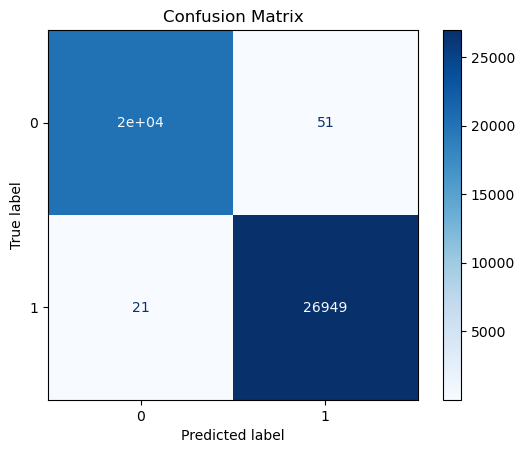

Model saved to url_classifier_model.joblib


In [19]:
# function to train and save the Random Forest model
def train_model_and_save(df, model_path='url_classifier_model.joblib'):
    
    X = df.drop(columns=['label'])
    y = df['label']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
    
    pipeline = create_training_pipeline(RandomForestClassifier(class_weight='balanced', random_state=42))
    pipeline.fit(X_train, y_train)

    y_pred = pipeline.predict(X_test)
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred, digits=4))

    ConfusionMatrixDisplay.from_estimator(pipeline, X_test, y_test, cmap='Blues')
    plt.title("Confusion Matrix")
    plt.show()

    joblib.dump(pipeline, model_path)
    print(f"Model saved to {model_path}")

# train model and save with the dataset
train_model_and_save(df)

In [ ]:
** Testing model

Accuracy: 0.9976675148430874
Classification Report:
               precision    recall  f1-score   support

           0     0.9975    0.9970    0.9973      2002
           1     0.9978    0.9982    0.9980      2714

    accuracy                         0.9977      4716
   macro avg     0.9976    0.9976    0.9976      4716
weighted avg     0.9977    0.9977    0.9977      4716



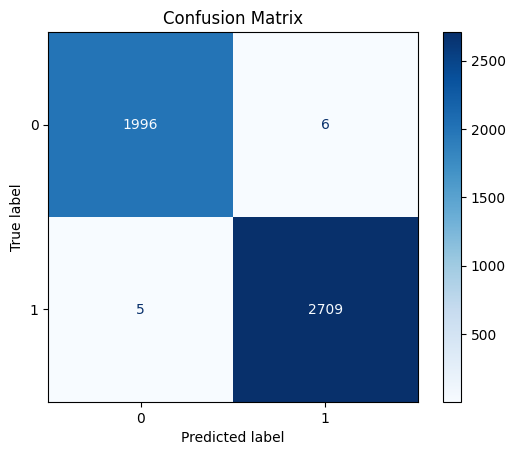

Model saved to url_classifier_model.joblib


In [64]:
eval_df = pd.read_csv('model_testing.csv')
train_model_and_save(eval_df)

**Building Feature Extraction Functions**

In [3]:
import requests
from bs4 import BeautifulSoup
from urllib.parse import urlparse, urljoin
import re

# URL feature extractor class
class URLFeatureExtractor:
    def __init__(self):
        self.features = {}


    def extract(self, url):
        """Extract features from a given URL"""
        self.features = {}
        self.http_accessible = True  # NEW FLAG

        # Extract URL-only features
        self.extract_basic_features(url)
        self.extract_no_of_subdomain(url)

        try:
            headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36'}
            response = requests.get(url, timeout=10, headers=headers)

            if response.status_code == 200:
                soup = BeautifulSoup(response.text, 'html.parser')
                self.extract_html_features(soup)
                self.extract_has_favicon(soup)
                self.extract_robot(url)
                self.extract_is_responsive(soup)
                self.extract_no_of_url_redirect(soup)
                self.extract_no_of_self_redirect(soup, url)
                self.extract_popup_and_iframe(soup)
                self.extract_has_copyright_info(soup)
                self.extract_has_social_net(soup)
                self.extract_has_submit_button(soup)
                self.extract_has_hidden_fields(soup)
                self.extract_bank_pay(soup)
                self.extract_no_of_self_ref(soup, url)
            else:
                raise Exception("Non-200 status")

        except Exception as e:
            print(f"Could not fetch content from the URL: {e}")
            print("URL is likely inactive or blocking requests. Only URL-based features will be used.")
            self.set_default_http_features()
            self.http_accessible = False  # SET THE FLAG

        return self.features


    def extract_basic_features(self, url):
        """Extract basic URL features"""
        try:
            parsed_url = urlparse(url)

            # Domain Length
            domain = parsed_url.netloc
            self.features['DomainLength'] = len(domain)

            # TLD
            tld = domain.split('.')[-1] if '.' in domain else ''
            self.features['TLD'] = tld

            # IsHTTPS
            self.features['IsHTTPS'] = 1 if parsed_url.scheme == 'https' else 0

        except Exception as e:
            print(f"Error extracting basic features: {e}")

    def extract_html_features(self, soup):
        """Extract HTML-related features"""
        # HasTitle
        self.features['HasTitle'] = 1 if soup.find('title') else 0

        # HasDescription
        meta_desc = soup.find('meta', attrs={'name': 'description'})
        self.features['HasDescription'] = 1 if meta_desc else 0

        # Count features
        self.features['NoOfImage'] = len(soup.find_all('img'))
        self.features['NoOfCSS'] = len(soup.find_all('link', rel='stylesheet'))
        self.features['NoOfJS'] = len(soup.find_all('script'))
        self.features['NoOfExternalRef'] = len(soup.find_all(['link', 'script', 'img'], src=re.compile('^https?://')))

    def extract_no_of_subdomain(self, url):
        """Extract number of subdomains"""
        try:
            parsed_url = urlparse(url)
            hostname = parsed_url.hostname
            parts = hostname.split('.')

            # Remove TLD to count subdomains
            if len(parts) <= 2:
                self.features['NoOfSubDomain'] = 0
            else:
                # Consider the main domain (last two parts) and count rest as subdomains
                self.features['NoOfSubDomain'] = len(parts) - 2
        except Exception as e:
            self.features['NoOfSubDomain'] = -1  # Invalid URL

    def extract_has_favicon(self, soup):
        """Check for favicon presence"""
        has_favicon = (soup.find('link', rel=re.compile('icon')) is not None or
                      soup.find('link', rel=re.compile('shortcut')) is not None or
                      soup.find('link', href=re.compile('favicon')) is not None)
        self.features['HasFavicon'] = 1 if has_favicon else 0

    def extract_robot(self, url):
        """Check for robots.txt"""
        try:
            parsed_url = urlparse(url)
            robots_url = f"{parsed_url.scheme}://{parsed_url.netloc}/robots.txt"
            response = requests.get(robots_url, timeout=5)
            self.features['Robots'] = 1 if response.status_code == 200 else 0
        except Exception as e:
            self.features['Robots'] = 0

    def extract_is_responsive(self, soup):
        """Check if website is responsive"""
        viewport = soup.find('meta', attrs={'name': 'viewport'}) is not None
        responsive_classes = bool(soup.find(class_=re.compile('responsive|container-fluid|col-')))

        # Check for media queries in style tags
        has_media_queries = False
        style_tags = soup.find_all('style')
        for style in style_tags:
            if '@media' in style.text:
                has_media_queries = True
                break

        self.features['IsResponsive'] = 1 if (viewport or responsive_classes or has_media_queries) else 0

    def extract_no_of_url_redirect(self, soup):
        """Extract number of URL redirects"""
        redirect_count = 0

        # Check meta refresh
        meta_refresh = soup.find_all('meta', attrs={'http-equiv': 'refresh'})
        redirect_count += len(meta_refresh)

        # Check JavaScript redirects
        script_tags = soup.find_all('script')
        redirect_patterns = [
            'window.location',
            'window.location.replace',
            'window.location.href',
            'http.open'
        ]

        for script in script_tags:
            if script.string:
                for pattern in redirect_patterns:
                    redirect_count += len(re.findall(pattern, script.string))

        self.features['NoOfURLRedirect'] = redirect_count

    def extract_no_of_self_redirect(self, soup, url):
        """Extract number of self redirects"""
        parsed_url = urlparse(url)
        current_origin = f"{parsed_url.scheme}://{parsed_url.netloc}"
        self_redirect_count = 0

        # Check meta refresh for self-redirect
        meta_refresh = soup.find_all('meta', attrs={'http-equiv': 'refresh'})
        for meta in meta_refresh:
            content = meta.get('content', '')
            if current_origin in content:
                self_redirect_count += 1

        # Check JavaScript self-redirects
        script_tags = soup.find_all('script')
        for script in script_tags:
            if script.string:
                self_redirect_count += len(re.findall(current_origin, script.string))

        self.features['NoOfSelfRedirect'] = self_redirect_count

    def extract_popup_and_iframe(self, soup):
        """Extract popup and iframe count"""
        popup_count = 0

        script_tags = soup.find_all('script')
        for script in script_tags:
            if script.string:
                popup_count += len(re.findall(r'window\.open', script.string))

        iframe_count = len(soup.find_all('iframe'))

        self.features['NoOfPopup'] = popup_count
        self.features['NoOfiFrame'] = iframe_count

    def extract_has_copyright_info(self, soup):
        """Check for copyright information"""
        has_copyright = (soup.text.lower().count('copyright') > 0 or
                        '©' in soup.text or
                        soup.find('footer') is not None)
        self.features['HasCopyrightInfo'] = 1 if has_copyright else 0

    def extract_has_social_net(self, soup):
        """Check for social network links"""
        social_networks = ['facebook', 'twitter', 'instagram', 'linkedin', 'youtube']
        has_social_net = False

        links = soup.find_all('a', href=True)
        for link in links:
            href = link['href'].lower()
            if any(network in href for network in social_networks):
                has_social_net = True
                break

        self.features['HasSocialNet'] = 1 if has_social_net else 0

    def extract_has_submit_button(self, soup):
        """Check for submit button"""
        has_submit_button = (soup.find('input', type='submit') is not None or
                           soup.find('button', type='submit') is not None or
                           soup.find('input', value=re.compile('submit')) is not None)
        self.features['HasSubmitButton'] = 1 if has_submit_button else 0

    def extract_has_hidden_fields(self, soup):
        """Check for hidden fields"""
        has_hidden_fields = soup.find('input', type='hidden') is not None
        self.features['HasHiddenFields'] = 1 if has_hidden_fields else 0

    def extract_bank_pay(self, soup):
        """Check for bank/pay keywords"""
        html_text = soup.text.lower()
        has_bank_pay = 'bank' in html_text or 'pay' in html_text
        self.features['Bank'] = 1 if has_bank_pay else 0
        self.features['Pay'] = 1 if has_bank_pay else 0

    def extract_no_of_self_ref(self, soup, url):
        """Extract number of self references"""
        parsed_url = urlparse(url)
        current_domain = parsed_url.hostname
        self_ref_count = 0

        links = soup.find_all('a', href=True)
        for link in links:
            try:
                href = link['href']
                link_url = urljoin(url, href)
                link_parsed = urlparse(link_url)
                if link_parsed.hostname == current_domain:
                    self_ref_count += 1
            except:
                # Invalid URL
                pass

        self.features['NoOfSelfRef'] = self_ref_count

    def set_default_http_features(self):
        """Set default values for features that require HTTP access"""
        self.features['HasFavicon'] = 0
        self.features['Robots'] = 0
        self.features['IsResponsive'] = 0
        self.features['NoOfURLRedirect'] = 0
        self.features['NoOfSelfRedirect'] = 0
        self.features['NoOfPopup'] = 0
        self.features['NoOfiFrame'] = 0
        self.features['HasCopyrightInfo'] = 0
        self.features['HasSocialNet'] = 0
        self.features['HasSubmitButton'] = 0
        self.features['HasHiddenFields'] = 0
        self.features['Bank'] = 0
        self.features['Pay'] = 0
        self.features['NoOfSelfRef'] = 0

    def get_all_features(self):
        """Return all features as a dictionary"""
        return self.features

**URL Prediction with trained model**

In [5]:
import joblib
import pandas as pd


def test_random_url(model_path, url):
    model = joblib.load(model_path)
    extractor = URLFeatureExtractor()
    features = extractor.extract(url)
    feature_df = pd.DataFrame([features])

    # Fill in any missing columns with default values
    for feature in ['NoOfImage', 'NoOfCSS', 'NoOfJS', 'NoOfExternalRef', 'HasTitle', 'HasDescription']:
        if feature not in feature_df.columns:
            feature_df[feature] = 0

    prediction = model.predict(feature_df)
    probability = model.predict_proba(feature_df)

    if not extractor.http_accessible:
        print("Note: Prediction is based only on URL-based features since the page could not be loaded.")
        print("Prediction may be less accurate.")

    return {
        'url': url,
        'prediction': prediction[0],
        'probability': probability[0],
        'features': features
    }

# test url
url = 'https://service-mitld.firebaseapp.com/'
result = test_random_url('url_classifier_model.joblib', url)
if result['prediction'] == 1:
    print("Prediction: Legitimate")
else:
    print("Prediction: Phishing")
print("Probability:", result['probability'])
print("Features:", result['features'])


Could not fetch content from the URL: HTTPSConnectionPool(host='service-mitld.firebaseapp.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: self-signed certificate in certificate chain (_ssl.c:1000)')))
URL is likely inactive or blocking requests. Only URL-based features will be used.
Note: Prediction is based only on URL-based features since the page could not be loaded.
Prediction may be less accurate.
Prediction: Phishing
Probability: [1. 0.]
Features: {'DomainLength': 29, 'TLD': 'com', 'IsHTTPS': 1, 'NoOfSubDomain': 1, 'HasFavicon': 0, 'Robots': 0, 'IsResponsive': 0, 'NoOfURLRedirect': 0, 'NoOfSelfRedirect': 0, 'NoOfPopup': 0, 'NoOfiFrame': 0, 'HasCopyrightInfo': 0, 'HasSocialNet': 0, 'HasSubmitButton': 0, 'HasHiddenFields': 0, 'Bank': 0, 'Pay': 0, 'NoOfSelfRef': 0}
